# <center> LEGO sets listing price prediction - regression model</center>

Machine Learning 1 Regression Project  
<b>Michał Thor, Bartłomiej Kowalczuk  </b>

In this project we wanted to created digit classifier that would be trained on data published on https://github.com/kensanata/numbers.  
Using that data we created a dataset that consits of 10.000 images (1000 images for each digit), all rescaled to 28x28 resolution, all in grayscale.

So basically, we transformed all the images into 1x784 vectors that has information about each pixel in the images. Then we used it as "one row" inputs into our models. 

We used Support Vector Machines algorithm, which after tuning, scored <b>92% accuracy</b> on the test set.  
Then we used Random Forest algorithm, which scored <b>91% accuracy</b> on the test set.  
Finally we used Convolutional Neural Network, which we tuned to gave us almost <b>97% accuracy</b>.

Firstly, we import all the necessary packages

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2_score

import keras
from keras import optimizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor



Nextly, we define some utillity functions that will help us in estimating/evaluating models.

We implement our own adjusted R-squared function, since sklearn package does not have one.

We also implement stepwise selection function for OLS model, which is based on the solution from:
https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

In [3]:
def adj_r2(r_sqr, n, p):
    r_2 = 1-(1-r_sqr)*(n-1)/(n-p-1)
    return r_2


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# <center>1. Understanding the data</center>

### Loading the dataset

In [4]:
df = pd.read_csv('lego_Sets.csv')

### Brief preview of the dataset structure

In [5]:
display(df.head(5))

ages  list_price  num_reviews  piece_count  play_star_rating  \
0  6-12       29.99          2.0        277.0               4.0   
1  6-12       19.99          2.0        168.0               4.0   
2  6-12       12.99         11.0         74.0               4.3   
3   12+       99.99         23.0       1032.0               3.6   
4   12+       79.99         14.0        744.0               3.2   

                                           prod_desc  prod_id  \
0  Catapult into action and take back the eggs fr...  75823.0   
1  Launch a flying attack and rescue the eggs fro...  75822.0   
2  Chase the piggy with lightning-fast Chuck and ...  75821.0   
3  Explore the architecture of the United States ...  21030.0   
4  Recreate the Solomon R. Guggenheim Museum® wit...  21035.0   

                                      prod_long_desc review_difficulty  \
0  Use the staircase catapult to launch Red into ...           Average   
1  Pilot Pig has taken off from Bird Island with ...              Easy   
2  Pitch speedy bird Chuck against the Piggy Car....              Easy   
3  Discover the architectural secrets of the icon...           Average   
4  Discover the architectural secrets of Frank Ll...       Challenging   

                         set_name  star_rating    theme_name  val_star_rating  \
0           Bird Island Egg Heist          4.5  Angry Birds™              4.0   
1              Piggy Plane Attack          5.0  Angry Birds™              4.0   
2                Piggy Car Escape          4.3  Angry Birds™              4.1   
3  United States Capitol Building          4.6  Architecture              4.3   
4   Solomon R. Guggenheim Museum®          4.6  Architecture              4.1   

  country  
0      US  
1      US  
2      US  
3      US  
4      US

Our goal is to predict value of the list_price variable - listing price of a certain toy in LEGO online store.

<b>country</b> variable is indicating which online store (from which country) is listing that item.

# <center>2. Preparing the dataset</center>

## 2.1 Removing useless data and fixing formats

Removing variables that would give no predictive power (information variables such as ID's or descriptions)

In [6]:
df = df.drop(['prod_desc', 
              'prod_id', 
              'prod_long_desc', 
              'set_name'],
             axis=1)

Changing categorical variables and list_price into right formats.

Also we are ordering review_difficulty since it is ordered scale of difficulty.

In [7]:
df.list_price = df.list_price.astype(float)
df['review_difficulty'] = df['review_difficulty'].astype("category")
df['review_difficulty'] = df['review_difficulty'].cat.reorder_categories(['Very Easy',
                                                               'Easy',
                                                               'Average',
                                                               'Challenging',
                                                               'Very Challenging'],
                                                                        ordered = True)
df['review_difficulty'] = df['review_difficulty'].cat.codes
df.theme_name = df.theme_name.astype(object)
df.ages = df.ages.astype(object)

## 2.2 Cleaning dataset from NA's

In [8]:
missing_data = pd.DataFrame({'Number of occurencies': df.isna().sum(),
                             'Percentage': 100*df.isna().sum()/len(df)
                            })
missing_data[missing_data['Number of occurencies'] > 0]

Number of occurencies  Percentage
num_reviews                        1620   13.212625
play_star_rating                   1775   14.476796
star_rating                        1620   13.212625
theme_name                            3    0.024468
val_star_rating                    1795   14.639915

Since the missings in star_rating (all 3 columns concerning them) are common for certain observations, maybe we can somehow reduce the number of them by filling missing values with computed value.

We mark the missings in review difficulty with a group code equal to -1.

We can see that star_rating has less NA's than play and val star_rating. We shall see if there is a correlation between those 3 variables. 

In [9]:
corr = df[['star_rating', 'play_star_rating', 'val_star_rating']].corr()
corr.style.background_gradient(cmap='coolwarm')

Let us compute means of ratios between star_rating for the whole dataset and use that ratio to create values to impute instead of NA's.

Because of slightly high correlation we decide to omit star_rating and leave the two other ratings (and since they all have same number of NA's)

In [10]:
df['star/play'] = df['star_rating']/df['play_star_rating']
df['star/val'] = df['star_rating']/df['val_star_rating']

star_p_mean = df['star/play'].mean()
star_v_mean = df['star/val'].mean()

df.loc[(df['play_star_rating'].isnull()) & (df['star_rating'].notna()), "play_star_rating"] = df["star_rating"]*star_p_mean
df.loc[(df['val_star_rating'].isnull()) & (df['star_rating'].notna()), "val_star_rating"] = df["star_rating"]*star_v_mean

df.drop(['star/play', 'star/val', 'star_rating'], axis=1, inplace=True)

That way we manage to narrow our total rows with NA's to 1620. Unfortunately there is no way to safely replace values for these observations (which all have at least 3 NA's) so we will omit them in further analysis.

In [11]:
df.loc[df.isnull().sum(1)>=3].index

df = df.dropna()

## 2.3 Checking for correlations and encoding categorical variables - using One Hot Encoding

Creating correlation matrix:

In [12]:
corr = df.drop(['list_price'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

There are no visible very high correlations (some ~0.5, but we decide to leave them in further analysis, because these are not worrying values).

In [14]:
cat_vars = []
cont_vars = []
for variable in df.columns:
    if df[variable].dtype==object:
        cat_vars.append(variable)
    else:
        cont_vars.append(variable)
        
num_of_cats = {}
for category in cat_vars:
    num_of_cats[category] = len(list(df[category].unique()))
    
print(num_of_cats)

{'ages': 31, 'theme_name': 38, 'country': 21}


We can see that all the variables have a lot of levels, let's see how different are the numbers of observations within each level on barplots below.

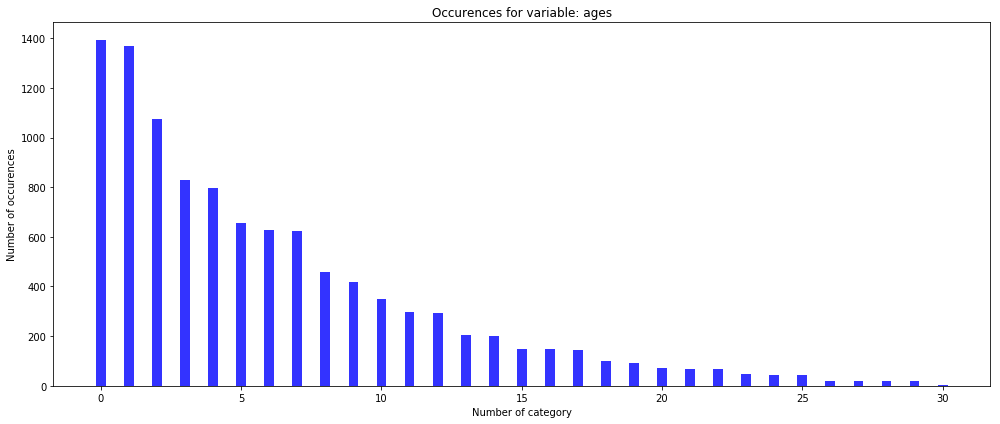

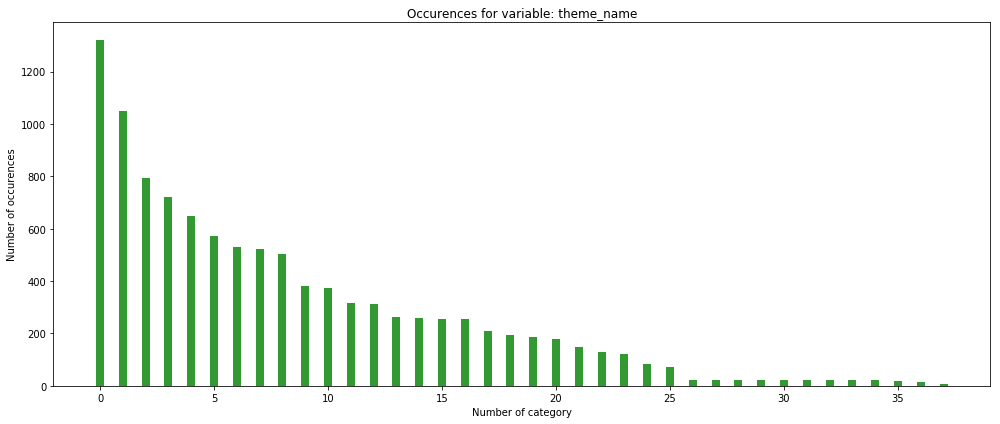

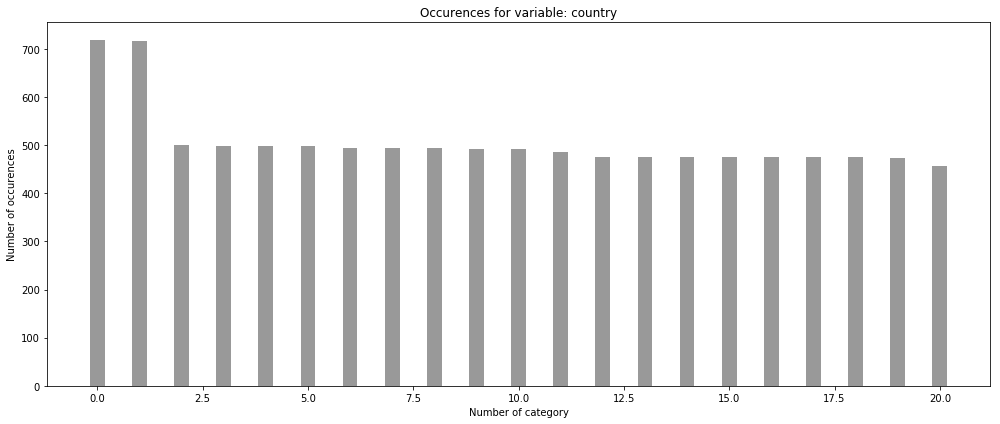

In [15]:
bar_width = 0.35
opacity = 0.8
colors = ["b","g","grey"]


for idx, var in enumerate(cat_vars):
    plt.figure(figsize=(14,6))
    boo = list(dict(df[var].value_counts()).values())
    leng = np.arange(len(list(dict(df[var].value_counts()).values())))
    rects = plt.bar(leng, boo, bar_width,
    alpha=opacity,
    color=colors[idx])
    plt.ylabel('Number of occurences')
    plt.xlabel('Number of category')
    plt.title('Occurences for variable: {}'.format(var))
    plt.tight_layout()
    plt.show()

Since there are no categories that would be very differently populated than the rest (they gradually descent) we decided to keep all the variables for one hot encoding.

Next we are creating dummy variables through one hot encoding for each category in categorical variables (omitting review_difficulty in which we introduced ordered categories).

In [16]:
df2 = pd.get_dummies(df, drop_first=True)

## 2.4 Splitting dataset into training and testing dataset

In [17]:
X, Y = df2.drop(['list_price'], axis=1), df2['list_price']

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=361)

In [18]:
df2.shape

(10638, 93)

We are left with 10638 observations and 92 variables which we have split into 70/30 train/test datasets. 

That way we are ready to begin estimating predictive models using 3 different methods.

# <center>3. Predicting data </center>

## 3.1 Linear Regression (OLS) model

Firstly, we are trying to estimate OLS linear regression model using all possible variables.

In [19]:
X_train_lin = sm.add_constant(X_train)
X_test_lin = sm.add_constant(X_test)
 
ols_model = sm.OLS(Y_train, X_train_lin).fit()
linear_pred = ols_model.predict(X_test_lin) 

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     533.6
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:57:30   Log-Likelihood:                -37322.
No. Observations:                7446   AIC:                         7.482e+04
Df Residuals:                    7357   BIC:                         7.544e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, linear_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, linear_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, linear_pred)))
print('Adjusted R-squared:', adj_r2(r2_score(Y_test, linear_pred), X_train.shape[0], X_train.shape[1]))

Mean Absolute Error: 16.757313097654322
Mean Squared Error: 1166.380221526104
Root Mean Squared Error: 34.15230916828471
Adjusted R-squared: 0.8653570978839871


We are using our own implementation of R-squared because we want to see value of the coefficient of determination on test data (by accessing <i>OLS.model.rsquared_adj</i> we get the value for training data). 

We can see promising values (although RMSE is quite high). Let us see how will the model with stepwise selected variables perform:

## 3.2 Linear Regression (OLS) model with stepwise selected features

We choose only variables with p-value of t-test < 0.05.

In [21]:
selected_vars = stepwise_selection(X_train, Y_train, verbose=False)

stepwise_X_train = X_train[selected_vars]
stepwise_X_test = X_test[selected_vars]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


In [22]:
stepwise_X_train = sm.add_constant(stepwise_X_train)
stepwise_X_test = sm.add_constant(stepwise_X_test)
 
stepwise_model = sm.OLS(Y_train, stepwise_X_train).fit()
stepwise_pred = stepwise_model.predict(stepwise_X_test) 

print(stepwise_model.summary())

                            OLS Regression Results                            
Dep. Variable:             list_price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1284.
Date:                Mon, 10 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:58:30   Log-Likelihood:                -37487.
No. Observations:                7446   AIC:                         7.505e+04
Df Residuals:                    7410   BIC:                         7.529e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [23]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, stepwise_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, stepwise_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, stepwise_pred)))
print('R-squared value:', adj_r2(r2_score(Y_test, stepwise_pred), stepwise_X_train.shape[0], stepwise_X_train.shape[1]))

Mean Absolute Error: 17.81808453192541
Mean Squared Error: 1245.1609961725383
Root Mean Squared Error: 35.28683885207824
R-squared value: 0.8573493362649673


We obtain worse results than with model build on the whole dataset. Let us try other method.

## 3.3 Elastic Net

Firstly, we are tuning the hyperparameters to find the best fit:

In [ ]:
eNet = ElasticNet(max_iter = 1000)

parametersGrid = {"alpha": [0.0001, 0.001, 0.005, 0.01, 0.1, 1.0],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1),
                 "tol": [ 0.00001, 0.0001, 0.01, 0.1],
                 "normalize": [True, False]}

grid = GridSearchCV(eNet, 
                    parametersGrid, 
                    scoring='r2', 
                    cv=5,
                    refit = 'r2')
grid.fit(X_train, Y_train)
grid_pred = grid.predict(X_test)
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

Now, we estimate data using best parameters for elastic net.

In [72]:
eNet = ElasticNet(max_iter = 1000,
                  alpha = 0.0001,
                  l1_ratio = 0.9,
                  tol = 0.00001)

eNet.fit(X_train, Y_train)
elastic_pred = eNet.predict(X_test)

c:\program files\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, elastic_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, elastic_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, elastic_pred)))
print('R-squared value:', adj_r2(r2_score(Y_test, elastic_pred), X_train.shape[0], X_train.shape[1]))

Mean Absolute Error: 16.740875751994192
Mean Squared Error: 1167.9068910568694
Root Mean Squared Error: 34.17465275693185
R-squared value: 0.8651808644290633


We can see that results are still not as good as when using simple Linear Regression. 

## 3.4 Neural Network

In [78]:
def create_model(momentum = 0.2,
                activation = 'softplus',
                learn_rate = 0.001,
                dropout_rate = 0.0,
                weight_constraint = 3,
                neurons = 100,
                init = 'lecun_uniform'
                optimizer = 'adagrad',
                normalize = True): 

    # create model
    NN_model = Sequential()
    NN_model.add(Dense(128, 
                   kernel_initializer=init,
                   input_dim = X_train.shape[1], 
                   activation=activation))

    # The Hidden Layers :
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))
    NN_model.add(Dropout(dropout_rate)) 
    NN_model.add(Dense(neurons, 
                       kernel_initializer=init,
                       activation=activation,
                      kernel_constraint=maxnorm(weight_constraint)))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer=init,
                       activation='linear'))

    
    NN_model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_absolute_error',
                           'mean_squared_error'])
    
    NN_model.fit(X_train, Y_train,
          epochs=300,
          batch_size=64)
    
    return NN_model


model = KerasRegressor(build_fn=create_model, 
                        epochs = 300, 
                        batch_size = 64,
                        verbose = 1)

SyntaxError: invalid syntax (<ipython-input-78-f299decf73a6>, line 8)

In [ ]:
def grid_search(model = model):
# Use scikit-learn to grid search 
    activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
    learn_rate = [0.0001, 0.0005, 0.001, 0.025, 0.005, 0.075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2]
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    weight_constraint=[1, 2, 3, 4, 5]
    neurons = [30, 100, 128, 256]
    init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
    normalize = [True, False]
    ##############################################################
    # grid search epochs, batch size
    epochs = [50, 100] # add 50, 100, 150 etc
    batch_size = [10, 32, 64, 100] # add 5, 10, 20, 40, 60, 80, 100 etc
    param_grid = dict(# epochs=epochs,
#                      batch_size=batch_size,
#                      activation=activation,
#                      momentum=momentum,
#                      learn_rate=learn_rate,
#                      dropout_rate=dropout_rate,
#                      weight_constraint=weight_constraint,
#                      neurons=neurons,
                     init=init,
#                      optimizer=optimizer,
#                      normalize=normalize
                     )
    ##############################################################
    grid = GridSearchCV(estimator=model, 
                        param_grid=param_grid, 
                        scoring=['r2'],
                        refit = 'r2',
                        n_jobs=1,
                        cv = 5)
    grid_result = grid.fit(X_train, Y_train) 
    ##############################################################
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_r2']
    stds = grid_result.cv_results_['std_test_r2']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
grid_search(model)

Epoch 1/300
7446/7446 [==============================] - 1s 89us/step - loss: 4803.1360 - mean_absolute_error: 24.5207 - mean_squared_error: 4803.1360
Epoch 2/300
7446/7446 [==============================] - 0s 39us/step - loss: 2484.2677 - mean_absolute_error: 20.8516 - mean_squared_error: 2484.2677
Epoch 3/300
7446/7446 [==============================] - 0s 37us/step - loss: 2429.1905 - mean_absolute_error: 20.5044 - mean_squared_error: 2429.1905
Epoch 4/300
7446/7446 [==============================] - 0s 35us/step - loss: 2443.6631 - mean_absolute_error: 20.4465 - mean_squared_error: 2443.6631
Epoch 5/300
7446/7446 [==============================] - 0s 36us/step - loss: 2383.4635 - mean_absolute_error: 20.2562 - mean_squared_error: 2383.4635
Epoch 6/300
7446/7446 [==============================] - 0s 38us/step - loss: 2370.9157 - mean_absolute_error: 20.1983 - mean_squared_error: 2370.9157
Epoch 7/300
7446/7446 [==============================] - 0s 37us/step - loss: 2357.1166 - mean

7446/7446 [==============================] - 0s 38us/step - loss: 1555.8276 - mean_absolute_error: 14.7692 - mean_squared_error: 1555.8276
Epoch 55/300
7446/7446 [==============================] - 0s 34us/step - loss: 1543.6965 - mean_absolute_error: 14.6745 - mean_squared_error: 1543.6965
Epoch 56/300
7446/7446 [==============================] - 0s 35us/step - loss: 1557.3801 - mean_absolute_error: 14.8361 - mean_squared_error: 1557.3801
Epoch 57/300
7446/7446 [==============================] - 0s 34us/step - loss: 1549.8008 - mean_absolute_error: 14.6772 - mean_squared_error: 1549.8008
Epoch 58/300
7446/7446 [==============================] - 0s 35us/step - loss: 1528.9058 - mean_absolute_error: 14.7651 - mean_squared_error: 1528.9058
Epoch 59/300
7446/7446 [==============================] - 0s 34us/step - loss: 1455.0056 - mean_absolute_error: 14.4593 - mean_squared_error: 1455.0056
Epoch 60/300
7446/7446 [==============================] - 0s 34us/step - loss: 1411.6901 - mean_absol

7446/7446 [==============================] - 0s 41us/step - loss: 566.6296 - mean_absolute_error: 10.3493 - mean_squared_error: 566.6296
Epoch 109/300
7446/7446 [==============================] - 0s 35us/step - loss: 472.1147 - mean_absolute_error: 9.9664 - mean_squared_error: 472.1147
Epoch 110/300
7446/7446 [==============================] - 0s 37us/step - loss: 484.8995 - mean_absolute_error: 9.9918 - mean_squared_error: 484.8995
Epoch 111/300
7446/7446 [==============================] - 0s 38us/step - loss: 413.8251 - mean_absolute_error: 9.5839 - mean_squared_error: 413.8251 0s - loss: 420.2760 - mean_absolute_error: 9.6010 - mean_squared_error: 420.27
Epoch 112/300
7446/7446 [==============================] - 0s 38us/step - loss: 527.1537 - mean_absolute_error: 10.1426 - mean_squared_error: 527.1537
Epoch 113/300
7446/7446 [==============================] - 0s 37us/step - loss: 452.4482 - mean_absolute_error: 9.8267 - mean_squared_error: 452.4482
Epoch 114/300
7446/7446 [========

In [ ]:
testing = create_model()
neural_pred = list(testing.predict(X_test)[:,0])

In [ ]:
testing = load_model("lego_neural.h5")
testing

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, neural_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, neural_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, neural_pred)))